# Purpose

### 2021-10-28
In this notebook we'll take a look at the subtopics in the v0.4.0 topic model.

To recap coverage:
- 19k subreddits
    - 14k selected because they have the most activity (posts, views, & comments)
    - 5k of these are geo-relevant to i18n target markets (these have lower activity levels)

---

The best model logged in mlfow has this UUID:<br>
`134cefe13ae34621a69fcc48c4d5fb71`

# Imports & notebook setup

In [ ]:
%load_ext google.colab.data_table

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# colab auth for BigQuery
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
# Attach google drive & import my python utility functions
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import sys
l_paths_to_append = [
    '/content/gdrive/MyDrive/Colab Notebooks',

    # need to append the path to subclu so that colab can import things properly
    '/content/gdrive/MyDrive/Colab Notebooks/subreddit_clustering_i18n'
]
for path_ in l_paths_to_append:
    if not path_ in sys.path:
        print(f"Appending: {path_}")
        sys.path.append(path_)

Mounted at /content/gdrive
Appending: /content/gdrive/MyDrive/Colab Notebooks
Appending: /content/gdrive/MyDrive/Colab Notebooks/subreddit_clustering_i18n


In [ ]:
# install subclu & libraries needed to read parquet files from GCS

# !pip install -e "/content/gdrive/MyDrive/Colab Notebooks/subreddit_clustering_i18n/"

In [ ]:
# Install needed to load data from GCS, for some reason not included in subclu?
# !pip install gcsfs

In [ ]:
# !pip list

In [ ]:
# Regular Imports
import os
from datetime import datetime

from google.cloud import bigquery

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib_venn import venn2_unweighted, venn3_unweighted


os.environ['GOOGLE_CLOUD_PROJECT'] = 'data-prod-165221'

In [ ]:
# subclu imports

# For reloading, need to force-delete some imported items
try:
    del LoadPosts, LoadSubreddits
except Exception:
    pass


from subclu.utils.hydra_config_loader import LoadHydraConfig
from subclu.data.data_loaders import LoadPosts, LoadSubreddits
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.utils.data_irl_style import get_colormap
from subclu.models.clustering_utils import fancy_dendrogram


setup_logging()
print_lib_versions([pd, np])

python		v 3.7.12
===
pandas		v: 1.1.5
numpy		v: 1.19.5


## install R module for visualizations

R has a nice module to visualize clusters, so let's give it a shot

In [ ]:
# %load_ext rpy2.ipython

In [ ]:
# %R install.packages('dendextend')

# Load subreddit metadata

This data is already in bigQuery so read it straight from there. We'll use it to filter out geo-relevant (German) subs.

Also add the latest ratings so that we can filter based on those.

In [ ]:
%%time

sql_geo_and_languages = f"""
-- select DE subreddits + get latest rating

SELECT 
    sl.subreddit_id
    , sl.subreddit_name
    , r.rating
    -- , r.subrating
    , r.version

    , slo.verdict
    , slo.quarantine

    , geo.country_name
    , geo.users_percent_in_country
    -- , sl.geo_relevant_countries
    , ambassador_subreddit
    , posts_for_modeling_count

    , primary_post_language
    , primary_post_language_percent
    , secondary_post_language
    , secondary_post_language_percent

    , geo_relevant_country_count
    , geo_relevant_country_codes
    , geo_relevant_subreddit

FROM `reddit-employee-datasets.david_bermejo.subclu_v0040_subreddit_languages` sl
LEFT JOIN (
    SELECT * FROM `data-prod-165221.ds_v2_postgres_tables.subreddit_lookup`
    # Look back 2 days because looking back 1-day could be an empty partition
    WHERE dt = (CURRENT_DATE() - 2)
) AS slo
    ON slo.subreddit_id = sl.subreddit_id
LEFT JOIN (
    SELECT * FROM `reddit-employee-datasets.david_bermejo.subclu_geo_subreddits_20210922`
    WHERE country_name = 'Germany'
) AS geo 
    ON sl.subreddit_id = geo.subreddit_id
LEFT JOIN (
    SELECT * FROM ds_v2_subreddit_tables.subreddit_ratings
    WHERE pt = '2021-10-24'
) AS r
    ON r.subreddit_id = sl.subreddit_id 
    
WHERE 1=1
    -- AND r.version = 'v2'
    -- AND COALESCE(r.rating, '') IN ('pg', 'pg13', 'g')
    AND COALESCE(slo.verdict, '') != 'admin-removed'
    AND COALESCE(slo.quarantine, false) != true
    AND (
        sl.geo_relevant_countries LIKE '%Germany%'
        OR sl.ambassador_subreddit = True
    )

ORDER BY users_percent_in_country ASC -- subreddit_name, ambassador_subreddit
;
"""

client = bigquery.Client()
df_geo_and_lang = client.query(sql_geo_and_languages).to_dataframe()
print(df_geo_and_lang.shape)

(831, 17)
CPU times: user 205 ms, sys: 14.3 ms, total: 219 ms
Wall time: 8.84 s


In [ ]:
df_geo_and_lang.head()

,subreddit_id,subreddit_name,rating,version,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,posts_for_modeling_count,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit
0,t5_4ckovw,buehne,None,None,None,False,None,NaN,True,9.0,German,0.333333,Danish,0.111111,NaN,None,False
1,t5_4p0iav,de_events,None,None,None,False,None,NaN,True,1.0,German,1.000000,None,NaN,NaN,None,False
2,t5_2otu32,nikolacorporation,pg,v3,None,False,Germany,0.160008,False,188.0,English,0.920213,Estonian,0.010638,1.0,DE,True
3,t5_vwvbb,vanmoofbicycle,pg,v1,None,False,Germany,0.160199,False,305.0,English,0.963934,None,NaN,1.0,DE,True
4,t5_2rq3g,trackmania,pg,v1,None,False,Germany,0.160615,False,958.0,English,0.927975,None,NaN,1.0,DE,True


In [ ]:
df_geo_and_lang.tail()

,subreddit_id,subreddit_name,rating,version,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,posts_for_modeling_count,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit
826,t5_2tz7b,braunschweig,None,None,None,False,Germany,0.956430,False,28.0,German,0.892857,English,0.071429,1.0,DE,True
827,t5_3255n,duschgedanken,None,None,None,False,Germany,0.956434,True,90.0,German,1.000000,None,NaN,1.0,DE,True
828,t5_2w4vt,bielefeld,None,None,None,False,Germany,0.957314,False,27.0,German,0.925926,English,0.037037,1.0,DE,True
829,t5_2ty5z,bundeswehr,None,None,None,False,Germany,0.959926,False,254.0,German,0.960630,English,0.031496,1.0,DE,True
830,t5_4o0ba2,nachthimmel,None,None,None,False,Germany,1.000000,True,18.0,German,0.833333,English,0.111111,NaN,None,False


# Load model labels

Ideally we could just pull the configuration data from github, but for now I'm just manually copying the artifact locations


In [ ]:
config_clust_v040 = LoadHydraConfig(
    config_name='v0.4.0_2021_10_14-use_multi_lower_case_false_00',
    config_path="../config/data_embeddings_to_cluster",
)

In [ ]:
run_uuid = '134cefe13ae34621a69fcc48c4d5fb71'
run_artifacts_uri = (
    'gs://i18n-subreddit-clustering/mlflow/mlruns/18/134cefe13ae34621a69fcc48c4d5fb71/artifacts'
)

gs_optimal_ks = f"{run_artifacts_uri}/optimal_ks/optimal_ks.parquet"
gs_model_labels = f"{run_artifacts_uri}/df_labels/df_labels.parquet"

In [ ]:
!gsutil ls $run_artifacts_uri

gs://i18n-subreddit-clustering/mlflow/mlruns/18/134cefe13ae34621a69fcc48c4d5fb71/artifacts/clustering.log
gs://i18n-subreddit-clustering/mlflow/mlruns/18/134cefe13ae34621a69fcc48c4d5fb71/artifacts/X_linkage/
gs://i18n-subreddit-clustering/mlflow/mlruns/18/134cefe13ae34621a69fcc48c4d5fb71/artifacts/clustering_model/
gs://i18n-subreddit-clustering/mlflow/mlruns/18/134cefe13ae34621a69fcc48c4d5fb71/artifacts/config/
gs://i18n-subreddit-clustering/mlflow/mlruns/18/134cefe13ae34621a69fcc48c4d5fb71/artifacts/df_accel/
gs://i18n-subreddit-clustering/mlflow/mlruns/18/134cefe13ae34621a69fcc48c4d5fb71/artifacts/df_labels/
gs://i18n-subreddit-clustering/mlflow/mlruns/18/134cefe13ae34621a69fcc48c4d5fb71/artifacts/df_supervised_metrics/
gs://i18n-subreddit-clustering/mlflow/mlruns/18/134cefe13ae34621a69fcc48c4d5fb71/artifacts/figures/
gs://i18n-subreddit-clustering/mlflow/mlruns/18/134cefe13ae34621a69fcc48c4d5fb71/artifacts/hydra/
gs://i18n-subreddit-clustering/mlflow/mlruns/18/134cefe13ae34621a69fc

### optimal values for K (cluster number)

In [ ]:
%%time
df_opt_ks = pd.read_parquet(gs_optimal_ks)
print(df_opt_ks.shape)

(7, 2)
CPU times: user 186 ms, sys: 35.3 ms, total: 221 ms
Wall time: 721 ms


### Labels for many values of k

We'll use the optimal values to filter out & keep only the labels we's use for One Feed.


Replace `predicted` to `majority` to show that the model is simply picking the majority lable, not really predicting it.

In [ ]:
%%time
col_new_model_order = 'model_distance_order'
col_primary_topic_rename = 'primary_topic_0921'


df_labels_full = pd.read_parquet(gs_model_labels)

# Rename to standardize
df_labels_full = (
    df_labels_full
    # Rename predicted to majority
    .rename(columns={c: c.replace('-predicted-', '_majority_') for c in df_labels_full.columns})
    # label makes more sense than labels
    .rename(columns={c: c.replace('_k_labels', '_k_label') for c in df_labels_full.columns if c.endswith('_k_labels')})
    .rename(columns={
        'model_leaves_list_order_left_to_right': col_new_model_order,
        'primary_topic': col_primary_topic_rename,
        })
    .sort_values(by=[col_new_model_order], ascending=True)
)

# convert labels to proper dtype (integer)
l_cols_label_all = [c for c in df_labels_full.columns if c.endswith('_label')]
df_labels_full[l_cols_label_all] = df_labels_full[l_cols_label_all].astype(int)
del l_cols_label_all

df_labels_full['posts_for_modeling_count'] = df_labels_full['posts_for_modeling_count'].fillna(0).astype(int)

print(df_labels_full.shape)

(19053, 65)
CPU times: user 172 ms, sys: 48.3 ms, total: 220 ms
Wall time: 662 ms


In [ ]:
df_labels_full.head()

,model_distance_order,subreddit_name,subreddit_id,primary_topic_0921,posts_for_modeling_count,010_k_label,014_k_label,020_k_label,030_k_label,040_k_label,050_k_label,052_k_label,060_k_label,070_k_label,080_k_label,090_k_label,100_k_label,110_k_label,120_k_label,130_k_label,140_k_label,150_k_label,160_k_label,170_k_label,180_k_label,190_k_label,200_k_label,210_k_label,220_k_label,230_k_label,240_k_label,248_k_label,250_k_label,351_k_label,405_k_label,010_k_majority_primary_topic,014_k_majority_primary_topic,020_k_majority_primary_topic,030_k_majority_primary_topic,040_k_majority_primary_topic,050_k_majority_primary_topic,052_k_majority_primary_topic,060_k_majority_primary_topic,070_k_majority_primary_topic,080_k_majority_primary_topic,090_k_majority_primary_topic,100_k_majority_primary_topic,110_k_majority_primary_topic,120_k_majority_primary_topic,130_k_majority_primary_topic,140_k_majority_primary_topic,150_k_majority_primary_topic,160_k_majority_primary_topic,170_k_majority_primary_topic,180_k_majority_primary_topic,190_k_majority_primary_topic,200_k_majority_primary_topic,210_k_majority_primary_topic,220_k_majority_primary_topic,230_k_majority_primary_topic,240_k_majority_primary_topic,248_k_majority_primary_topic,250_k_majority_primary_topic,351_k_majority_primary_topic,405_k_majority_primary_topic
2227,0,blackmetal,t5_2rta0,Music,1169,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music
10817,1,metal,t5_2qhud,Music,1038,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music
4531,2,deathmetal,t5_2r5w5,Music,670,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music
16920,3,thrashmetal,t5_2s66e,Music,285,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music
16447,4,technicaldeathmetal,t5_2s8ge,Music,355,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music


### Filter to only k-optimal columns

Makes it easy to remove noise & understand cut-offs better

In [ ]:
l_cols_label_core = [
    col_new_model_order,
    'posts_for_modeling_count',
    'subreddit_id',
    'subreddit_name',
    col_primary_topic_rename,
]

cols_top_k = [c for c in df_labels_full.columns 
              if any(c.startswith(k_) for k_ in df_opt_ks[df_opt_ks['k'] >= 50]['col_prefix'].unique())
              ]

df_labels = (
    df_labels_full[l_cols_label_core + cols_top_k]
    .sort_values(by=[col_new_model_order], ascending=True)
).copy()


# move "k" to front so that we don't get bigQuery errors
df_labels = (
    df_labels
    .rename(columns={c: f"k{c.replace('_k_', '_')}" for c in df_labels.columns if '_k_' in c})
)

counts_describe(df_labels)

,dtype,count,unique,unique-percent,null-count,null-percent
model_distance_order,int64,"19,053","19,053",100.00%,0,0.00%
posts_for_modeling_count,int64,"19,053","1,175",6.17%,0,0.00%
subreddit_id,object,"19,053","19,053",100.00%,0,0.00%
subreddit_name,object,"19,053","19,053",100.00%,0,0.00%
primary_topic_0921,object,"15,929",51,0.32%,"3,124",16.40%
k052_label,int64,"19,053",52,0.27%,0,0.00%
k100_label,int64,"19,053",100,0.52%,0,0.00%
k248_label,int64,"19,053",248,1.30%,0,0.00%
k351_label,int64,"19,053",351,1.84%,0,0.00%
k405_label,int64,"19,053",405,2.13%,0,0.00%


# Check music clusters

Music is a topic where we expect multiple genres, so let's see how well this model picks up on that.

In [ ]:
value_counts_and_pcts(df_labels, col_primary_topic_rename, top_n=10)

,primary_topic_0921-count,primary_topic_0921-percent,primary_topic_0921-pct_cumulative_sum
nan,"3,124",16.4%,16.4%
Gaming,"2,472",13.0%,29.4%
Technology,"1,058",5.6%,34.9%
Internet Culture and Memes,816,4.3%,39.2%
Place,794,4.2%,43.4%
Music,680,3.6%,46.9%
Funny/Humor,655,3.4%,50.4%
Sports,542,2.8%,53.2%
Television,540,2.8%,56.1%
Mature Themes and Adult Content,520,2.7%,58.8%


## At k=052

- 3 subreddits contain 91.8% of music-related subreddits
- 5 subreddits contain 95.5% of music-related subreddits


In [ ]:
value_counts_and_pcts(
    df_labels[df_labels[col_primary_topic_rename] == 'Music'],
    ['k052_label'],  # ['030_k-label', '052_k-label'],
    # sort_index=True,
    count_type='subreddits',
    cumsum=True,
    top_n=20,
).set_caption(f"Count of subreddits for Music-related clusters")

,subreddits_count,percent_of_subreddits,cumulative_percent_of_subreddits
k052_label,,,
1,475,69.9%,69.9%
28,110,16.2%,86.0%
2,39,5.7%,91.8%
48,18,2.6%,94.4%
30,8,1.2%,95.6%
47,6,0.9%,96.5%
12,3,0.4%,96.9%
21,3,0.4%,97.4%
11,3,0.4%,97.8%


## Digging into k=100
We see that 

In [ ]:
value_counts_and_pcts(
    df_labels[
        ((df_labels[col_primary_topic_rename] == 'Music') &
         (df_labels['k052_label'].isin([1, 28, 2, 48, 30]))
        )
    ]
    ,
    ['k052_label', 'k100_label', 'k248_label'],
    sort_index=True,
    count_type='subreddits',
    cumsum=False,
    top_n=20,
).set_caption(f"Count of subreddits for Music-related clusters. Only top 52-k clusters")

# Show Dendrogram at n=52

## Load linkage data

In [ ]:
# !gsutil ls $run_artifacts_uri

In [ ]:
path_gs_linkage = f"{run_artifacts_uri}/X_linkage"

!gsutil ls $path_gs_linkage

gs://i18n-subreddit-clustering/mlflow/mlruns/18/134cefe13ae34621a69fcc48c4d5fb71/artifacts/X_linkage/X_linkage.csv
gs://i18n-subreddit-clustering/mlflow/mlruns/18/134cefe13ae34621a69fcc48c4d5fb71/artifacts/X_linkage/X_linkage.parquet


In [ ]:
%%time

X_linkage = pd.read_parquet(
    f"{path_gs_linkage}/X_linkage.parquet"
)
print(X_linkage.shape)

(19052, 4)
CPU times: user 33 ms, sys: 8.89 ms, total: 41.9 ms
Wall time: 468 ms


## Show dendrogram

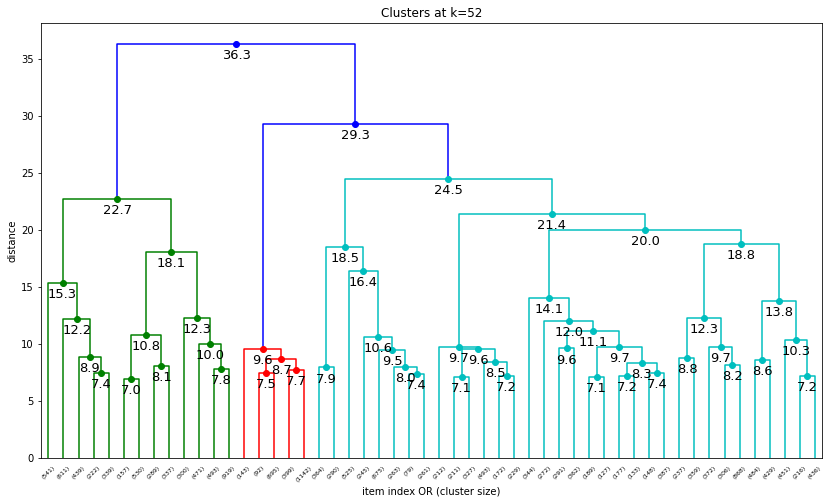

In [ ]:
p_ = 52
fancy_dendrogram(
    X_linkage,
    plot_title=f"Clusters at k={p_}",
    annotate_above=X_linkage['distance'].quantile(q=0.985),
    truncate_mode='lastp',
    p=p_,
    orientation='top',
    # labels=df_52_color_labels['model_leaves_list_order_left_to_right'].to_list(),
    # link_color_func=lambda x: d_cluster_colors.get(x, '#929292'),
    show_leaf_counts=True, leaf_rotation=45,
    # show_contracted=False,
    # color_threshold=15.3,
)
plt.show()

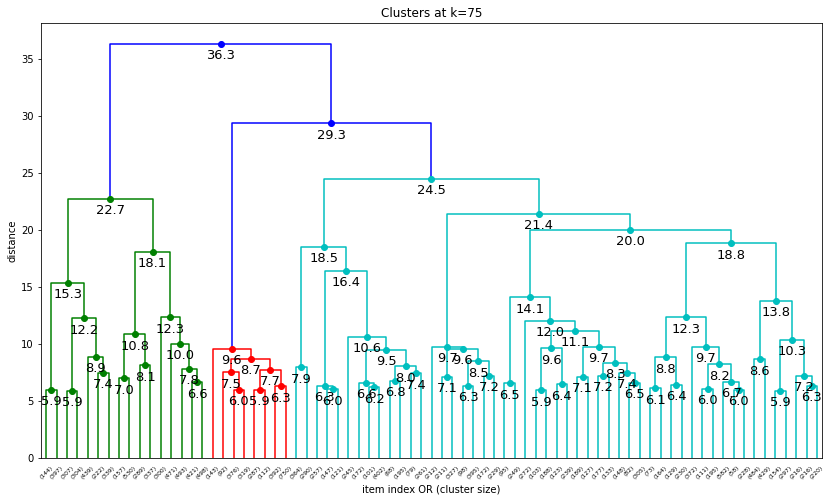

In [ ]:
p_ = 75
fancy_dendrogram(
    X_linkage,
    plot_title=f"Clusters at k={p_}",
    annotate_above=X_linkage['distance'].quantile(q=0.985),
    truncate_mode='lastp',
    p=p_,
    orientation='top',
    # labels=df_52_color_labels['model_leaves_list_order_left_to_right'].to_list(),
    # link_color_func=lambda x: d_cluster_colors.get(x, '#929292'),
    show_leaf_counts=True, leaf_rotation=45,
    # show_contracted=False,
    # color_threshold=15.3,
)
plt.show()

### Try to color clusters in dendogra [WIP/ ignore for now]

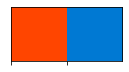

In [ ]:
sns.palplot(get_colormap(2, 'discrete', return_as_list=True))

In [ ]:
# # Create color map for clusters
# l_cluster_names = [i for i in range(1, 53)]
# # set all colors to blue by default
# d_cluster_colors = {i: get_colormap(2, 'discrete', return_as_list=True)[1] for i in l_cluster_names}

# # highlight music clusters with red color
# for c_ in df_labels[df_labels['primary_topic'] == 'Music']['052_k-label'].unique():
#     d_cluster_colors[c_] = get_colormap(2, 'discrete', return_as_list=True)[0]


In [ ]:
# so it turns out we need to go all the way to the leaves, not the cluster node.
#. So let's assign color to each leaf, not each node/cluster
df_52_color_labels = df_labels[[
    'model_leaves_list_order_left_to_right', 'subreddit_name', 'primary_topic', '052_k-label',
]].copy()

# set all colors to blue by default
df_52_color_labels['cluster_colors'] = np.where(
    df_52_color_labels['primary_topic'] == 'Music',
    get_colormap(2, 'discrete', return_as_list=True)[0],
    get_colormap(2, 'discrete', return_as_list=True)[1]
)

In [ ]:
d_cluster_colors = (
    df_52_color_labels[['model_leaves_list_order_left_to_right', 'cluster_colors']]
    .set_index('model_leaves_list_order_left_to_right')
    .to_dict()
)

In [ ]:
X_linkage[X_linkage['children_1'] == 38061]

,children_0,children_1,distance,count
19022,37980,38061,8.857997,1000


## Check top 5 subs for each of the music clusters

In [ ]:
l_music_clusters = df_labels[df_labels[col_primary_topic_rename] == 'Music']['k052_label'].unique()

l_prefixes_to_ignore = [
    'k030_',
    # 'k405_'    
]

df_music_clusters = (
    df_labels
    [df_labels['k052_label'].isin(l_music_clusters)]
    # exclude the columns at the edges (030 and 405)
    [[c for c in df_labels.columns if all([not c.startswith(pfx_) for pfx_ in l_prefixes_to_ignore])]]
).copy()

df_music_clusters.shape

(8705, 15)

In [ ]:
# df_music_clusters.head(10)

In [ ]:
n_music_subs_per_cluster = 3
n_non_music_subs_per_cluster = 2
# cluster_col = 'k052_label'
cluster_col = 'k248_label'

mask_music_labeled_subs = df_music_clusters[col_primary_topic_rename] == 'Music'

df_music_clusters_sample = pd.concat(
    [
        df_music_clusters[mask_music_labeled_subs]
        .sort_values(by=['posts_for_modeling_count'], ascending=False)
        .groupby(cluster_col)
        .head(n_music_subs_per_cluster)
        ,
        df_music_clusters[~mask_music_labeled_subs]
        .sort_values(by=['posts_for_modeling_count'], ascending=False)
        .groupby(cluster_col)
        .head(n_non_music_subs_per_cluster)
        ,
    ],
    axis=0,
    ignore_index=False,
).sort_values(by=[cluster_col, col_new_model_order], ascending=True)

print(df_music_clusters_sample.shape)

(287, 15)


In [ ]:
style_df_numeric(
    df_music_clusters_sample.iloc[:28, :]    
    # .drop(['model_leaves_list_order_left_to_right'], axis=1)
    ,
    l_bar_simple=[c for c in df_music_clusters.columns if 'label' in c]
)

,model_distance_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic
13693,23,"1,200",t5_2qjx5,punk,Activism,1,1,1,1,1,Music,Music,Music,Music,Music
5362,58,"1,200",t5_2qm8v,edm,Music,1,1,1,1,1,Music,Music,Music,Music,Music
10004,64,"1,200",t5_2rlyh,lofi,Music,1,1,1,1,1,Music,Music,Music,Music,Music
13571,70,"1,200",t5_2xs9o,promoteyourmusic,Music,1,1,1,1,1,Music,Music,Music,Music,Music
6826,116,"1,200",t5_2rmsp,gamemusic,Gaming,1,1,1,1,1,Music,Music,Music,Music,Music
7793,146,"1,200",t5_2suwz,hiphopcirclejerk,Internet Culture and Memes,1,2,2,2,2,Music,Music,Music,Music,Music
2791,150,"1,200",t5_1uyb31,calibanging,None,1,2,2,2,2,Music,Music,Music,Music,Music
7794,165,"1,200",t5_2rh4c,hiphopheads,Music,1,2,2,2,2,Music,Music,Music,Music,Music
9169,166,"1,200",t5_2v28g,kendricklamar,Music,1,2,2,2,2,Music,Music,Music,Music,Music
6523,175,"1,200",t5_2tyek,frankocean,Music,1,2,2,2,2,Music,Music,Music,Music,Music


In [ ]:
style_df_numeric(
    df_music_clusters_sample.iloc[-25:, :]
    # .sort_values(by=[cluster_col, 'model_leaves_list_order_left_to_right'], ascending=True)
    ,
    l_bar_simple=[c for c in df_music_clusters.columns if 'label' in c]
)

,model_distance_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic
2831,"17,051","1,200",t5_2qk80,camping,Outdoors and Nature,48,89,222,318,367,Place,Music,Outdoors and Nature,Outdoors and Nature,Outdoors and Nature
1551,"17,073",868,t5_2rev7,aves,Music,48,89,223,319,368,Place,Music,Music,Music,Music
2414,"17,077","1,200",t5_2rg7a,bonnaroo,None,48,89,223,319,368,Place,Music,Music,Music,Music
6071,"17,078",664,t5_2re9k,festivals,Music,48,89,223,319,368,Place,Music,Music,Music,Music
10097,"17,093",742,t5_3m3sj,lostlandsmusicfest,Music,48,89,223,319,368,Place,Music,Music,Music,Music
18226,"17,097","1,200",t5_2te6p,waltdisneyworld,Place,48,89,223,319,368,Place,Music,Music,Music,Music
12568,"17,129","1,200",t5_2qpoo,ottawa,Place,48,90,224,320,369,Place,Place,Place,Place,Place
2789,"17,130","1,200",t5_2qn40,calgary,Place,48,90,224,320,369,Place,Place,Place,Place,Place
3626,"17,282","1,200",t5_2r373,columbus,Place,48,90,225,322,371,Place,Place,Place,Place,Place
10266,"17,314","1,200",t5_2r8rz,madisonwi,Place,48,90,225,322,371,Place,Place,Place,Place,Place


# Sample/check overall clusters

In [ ]:
n_subs_per_cluster = 3
# cluster_col = 'k052_label'
cluster_col = 'k248_label'


df_labels_sample = (
    df_labels
    .sort_values(by=['posts_for_modeling_count'], ascending=False)
    .groupby(cluster_col)
    .head(n_subs_per_cluster)

    .sort_values(by=[cluster_col, col_new_model_order], ascending=True)
)

print(df_labels_sample.shape)

(744, 15)


In [ ]:
style_df_numeric(
    df_labels_sample.iloc[:28, :]    
    # .drop([col_new_model_order], axis=1)
    ,
    l_bar_simple=[c for c in df_labels_sample.columns if 'label' in c]
)

,model_distance_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic
8411,35,"1,200",t5_2qhz6,indie,Music,1,1,1,1,1,Music,Music,Music,Music,Music
13929,42,"1,200",t5_3jzsk,ravedj,Music,1,1,1,1,1,Music,Music,Music,Music,Music
11537,138,"1,200",t5_2svj1,namethatsong,Music,1,1,1,1,1,Music,Music,Music,Music,Music
17576,158,"1,200",t5_3fvkh,ukdrill,Music,1,2,2,2,2,Music,Music,Music,Music,Music
3302,159,"1,200",t5_3k1kj,chiraqology,Music,1,2,2,2,2,Music,Music,Music,Music,Music
17136,160,"1,200",t5_vbkcx,torontology,Music,1,2,2,2,2,Music,Music,Music,Music,Music
4500,215,"1,200",t5_39rmm,deadandcompany,Music,1,2,3,3,3,Music,Music,Music,Music,Music
12997,246,"1,200",t5_2ql29,phish,Music,1,2,3,3,3,Music,Music,Music,Music,Music
7325,248,"1,200",t5_2qpnj,gratefuldead,Music,1,2,3,3,3,Music,Music,Music,Music,Music
8416,418,"1,200",t5_2zj24,indieheads,Music,1,2,4,5,5,Music,Music,Music,Music,Music


In [ ]:
style_df_numeric(
    df_labels_sample.iloc[120:135, :]    
    # .drop([col_new_model_order], axis=1)
    ,
    l_bar_simple=[c for c in df_labels_sample.columns if 'label' in c]
)

,model_distance_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic
12713,"4,293","1,200",t5_4xxkx6,paperearmate,Gaming,12,18,41,56,62,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes
16454,"4,344","1,200",t5_38gjk,technoblade,Podcasts and Streamers,12,18,41,56,62,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes
15530,"4,345","1,200",t5_2rh21,sonicthehedgehog,Gaming,12,18,41,56,62,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes
59,"4,455","1,200",t5_3ee85,2meirl4meirl,Internet Culture and Memes,12,18,42,59,65,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes
10627,"4,458","1,200",t5_2vegg,me_irl,Funny/Humor,12,18,42,59,65,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes
10714,"4,459","1,200",t5_2s5ti,meirl,Internet Culture and Memes,12,18,42,59,65,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes
1085,"4,530","1,200",t5_2qlht,argentina,"Culture, Race, and Ethnicity",12,19,43,60,66,Internet Culture and Memes,Internet Culture and Memes,Funny/Humor,Funny/Humor,Funny/Humor
10757,"4,544","1,200",t5_258mfq,memesita,Internet Culture and Memes,12,19,43,60,66,Internet Culture and Memes,Internet Culture and Memes,Funny/Humor,Funny/Humor,Funny/Humor
1721,"4,547","1,200",t5_2oddo7,ballutverso,Funny/Humor,12,19,43,60,66,Internet Culture and Memes,Internet Culture and Memes,Funny/Humor,Funny/Humor,Funny/Humor
12440,"4,633","1,200",t5_x8w0y,oompasubs,Podcasts and Streamers,12,19,44,61,68,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes


In [ ]:
style_df_numeric(
    df_labels_sample.iloc[220:235, :]    
    # .drop([col_new_model_order], axis=1)
    ,
    l_bar_simple=[c for c in df_labels_sample.columns if 'label' in c]
)

,model_distance_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic
16546,"7,504","1,200",t5_2sg5b,terraria,Gaming,18,31,74,104,118,Gaming,Gaming,Gaming,Gaming,Gaming
10616,"7,506","1,200",t5_2tu23,mcpe,Gaming,18,31,74,104,118,Gaming,Gaming,Gaming,Gaming,Gaming
4390,"7,564","1,200",t5_2sazo,darksouls,Gaming,18,31,75,105,120,Gaming,Gaming,Gaming,Gaming,Gaming
10475,"7,576","1,200",t5_n9nn1,market76,Gaming,18,31,75,105,120,Gaming,Gaming,Gaming,Gaming,Gaming
6447,"7,579","1,200",t5_jm6y3,fortnitefashion,Gaming,18,31,75,105,120,Gaming,Gaming,Gaming,Gaming,Gaming
15788,"7,750","1,200",t5_2qpp6,starcraft,Gaming,18,31,76,107,123,Gaming,Gaming,Gaming,Gaming,Gaming
16423,"7,771","1,200",t5_1136aw,teamfighttactics,Gaming,18,31,76,107,123,Gaming,Gaming,Gaming,Gaming,Gaming
1076,"7,774","1,200",t5_3mynb,arenaofvalor,Gaming,18,31,76,107,123,Gaming,Gaming,Gaming,Gaming,Gaming
5649,"7,931","1,200",t5_3aq6o,escapefromtarkov,Gaming,18,31,77,108,124,Gaming,Gaming,Gaming,Gaming,Gaming
4571,"7,933","1,200",t5_3iufz,deeprockgalactic,Gaming,18,31,77,108,124,Gaming,Gaming,Gaming,Gaming,Gaming


# Check subreddits around specific subreddits

This might be easier to understand concretely & provide better examples

In [ ]:
l_subs_to_qa = [
    # 'christianmusic',
    # 'dune',
    # 'fussball',
    # 'de',
    'vosfinances',
    'france',
    # 'frenchrap',
    'mangafr',
    'paris',
]

n_subs_nearby = 4
for sub_name in l_subs_to_qa:
    sub_rank = df_labels.loc[df_labels['subreddit_name'] == sub_name, col_new_model_order].values[0]

    display(
        style_df_numeric(
            df_labels
            [df_labels[col_new_model_order].between(sub_rank - n_subs_nearby, sub_rank + n_subs_nearby, inclusive='both')]
            # .drop(['posts_for_modeling_count'], axis=1)
            ,
            l_bar_simple=[c for c in df_labels.columns if 'label' in c]
        )
    )

,model_distance_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic
10861,"18,919",630,t5_2rorh8,mexicofinanciero,"Business, Economics, and Finance",52,99,246,349,402,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance"
1951,"18,920",90,t5_3jeou,beleggen,"Business, Economics, and Finance",52,99,246,349,402,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance"
6160,"18,921","1,200",t5_35m5e,finanzen,"Business, Economics, and Finance",52,99,246,349,402,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance"
9946,"18,922",600,t5_2clhc5,literaciafinanceira,None,52,99,246,349,402,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance"
18145,"18,923",342,t5_37aoh,vosfinances,"Business, Economics, and Finance",52,99,246,349,402,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance"
8571,"18,924",722,t5_38ilc,investimentos,"Business, Economics, and Finance",52,99,246,349,402,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance"
8698,"18,925",638,t5_3isqn,italiapersonalfinance,"Business, Economics, and Finance",52,99,246,349,402,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance"
12996,"18,926","1,044",t5_32eoz,phinvest,"Business, Economics, and Finance",52,99,246,349,402,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance"
10355,"18,927",261,t5_35kex,malaysianpf,"Business, Economics, and Finance",52,99,246,349,402,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance"


,model_distance_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic
8454,"9,548",112,t5_484z6v,infos_france,None,23,38,100,141,160,Politics,Politics,Politics,Politics,Place
18841,"9,549","1,200",t5_47quxa,yahooqr,None,23,38,100,141,160,Politics,Politics,Politics,Politics,Place
925,"9,550",50,t5_2djd4u,antiracisme,"Culture, Race, and Ethnicity",23,38,100,141,160,Politics,Politics,Politics,Politics,Place
6513,"9,551",111,t5_29145x,francedigeste,None,23,38,100,141,160,Politics,Politics,Politics,Politics,Place
6509,"9,552","1,200",t5_2qhjz,france,Place,23,38,100,141,160,Politics,Politics,Politics,Politics,Place
6510,"9,553",186,t5_4c3l03,france6,None,23,38,100,141,160,Politics,Politics,Politics,Politics,Place
6511,"9,554",92,t5_48tn5k,francebbr,None,23,38,100,141,160,Politics,Politics,Politics,Politics,Place
12757,"9,555",103,t5_2xe8t,paslegorafi,None,23,38,100,141,160,Politics,Politics,Politics,Politics,Place
10589,"9,556",552,t5_2xnq8,mayotte,None,23,38,100,141,160,Politics,Politics,Politics,Politics,Place


,model_distance_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic
10397,553,"1,200",t5_3p7rg,mangacollectors,Anime,2,3,5,6,6,Anime,Anime,Anime,Anime,Anime
10399,554,47,t5_4thzyd,mangade,"Reading, Writing, and Literature",2,3,5,6,6,Anime,Anime,Anime,Anime,Anime
10404,555,36,t5_35bgn0,mangaitalia,None,2,3,5,6,6,Anime,Anime,Anime,Anime,Anime
10396,556,65,t5_2cdgea,manga_br,None,2,3,5,6,6,Anime,Anime,Anime,Anime,Anime
10402,557,"1,121",t5_ne3w4,mangafr,Anime,2,3,5,6,6,Anime,Anime,Anime,Anime,Anime
6034,558,488,t5_4ttqv7,feijoadanerdeotaku,None,2,3,5,6,6,Anime,Anime,Anime,Anime,Anime
861,559,285,t5_3nvds3,anitokio,None,2,3,5,6,6,Anime,Anime,Anime,Anime,Anime
4674,560,109,t5_4il4sl,designe,None,2,3,5,6,6,Anime,Anime,Anime,Anime,Anime
837,561,454,t5_1465tr,animekisa,Art,2,3,5,6,6,Anime,Anime,Anime,Anime,Anime


,model_distance_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic
453,"17,645",79,t5_2tk47,aixmarseille,None,49,91,228,325,376,Place,Place,Place,Place,Place
7363,"17,646",79,t5_2skay,grenoble,None,49,91,228,325,376,Place,Place,Place,Place,Place
14425,"17,647",12,t5_3928f,rouen,None,49,91,228,325,376,Place,Place,Place,Place,Place
1263,"17,648",213,t5_2zkfk,askfrance,None,49,91,228,325,376,Place,Place,Place,Place,Place
12744,"17,649",399,t5_2qkoi,paris,Place,49,91,228,325,376,Place,Place,Place,Place,Place
2446,"17,650",24,t5_2stgm,bordeaux,None,49,91,228,325,376,Place,Place,Place,Place,Place
11838,"17,651",17,t5_3jgid,nicefrance,None,49,91,228,325,376,Place,Place,Place,Place,Place
14146,"17,652",14,t5_2tx5n,rennes,None,49,91,228,325,376,Place,Place,Place,Place,Place
11552,"17,653",21,t5_2sq2i,nantes,None,49,91,228,325,376,Place,Place,Place,Place,Place


In [ ]:
l_subs_to_qa = [
    'olympics',
    'datingde',
    'clownwelt',
    '4chan',
    'berlinsocialclub',
    # 'vosfinances',
    # 'france',
    # 'frenchrap',
    # 'mangafr',
    # 'paris',
]

n_subs_nearby = 6
for sub_name in l_subs_to_qa:
    sub_rank = df_labels.loc[df_labels['subreddit_name'] == sub_name, col_new_model_order].values[0]

    display(
        style_df_numeric(
            df_labels
            [df_labels[col_new_model_order].between(sub_rank - n_subs_nearby, sub_rank + n_subs_nearby, inclusive='both')]
            # .drop(['posts_for_modeling_count'], axis=1)
            ,
            l_bar_simple=[c for c in df_labels.columns if 'label' in c]
        )
    )

,model_distance_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic
8389,"9,287",220,t5_2uzik,indiansports,Sports,21,36,95,135,154,Sports,Sports,Sports,Sports,Sports
15706,"9,288",584,t5_2qgzy,sports,Sports,21,36,95,135,154,Sports,Sports,Sports,Sports,Sports
18274,"9,289",21,t5_4nba24,wassersport,None,21,36,95,135,154,Sports,Sports,Sports,Sports,Sports
12735,"9,290",77,t5_3dqouq,parasport,None,21,36,95,135,154,Sports,Sports,Sports,Sports,Sports
15521,"9,291",227,t5_4cf0rg,sommerspiele,Sports,21,36,95,135,154,Sports,Sports,Sports,Sports,Sports
12328,"9,292",32,t5_4q9dug,olimpiadas,Sports,21,36,95,135,154,Sports,Sports,Sports,Sports,Sports
12337,"9,293","1,200",t5_21of,olympics,Sports,21,36,95,135,154,Sports,Sports,Sports,Sports,Sports
13153,"9,294",42,t5_4c7a6m,platzreife,None,21,36,95,135,154,Sports,Sports,Sports,Sports,Sports
13533,"9,295",116,t5_2wb3n,progolf,Sports,21,36,95,135,154,Sports,Sports,Sports,Sports,Sports
16527,"9,296","1,200",t5_2qiq1,tennis,Sports,21,36,95,135,154,Sports,Sports,Sports,Sports,Sports


,model_distance_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic
15092,"16,426",606,t5_2sw51,shittyaskscience,Internet Culture and Memes,47,84,208,302,349,Religion and Spirituality,Internet Culture and Memes,Learning and Education,Learning and Education,Learning and Education
1331,"16,427","1,200",t5_21turx,askteenboys,None,47,84,208,302,349,Religion and Spirituality,Internet Culture and Memes,Learning and Education,Learning and Education,Learning and Education
1332,"16,428","1,200",t5_21tv8q,askteengirls,Learning and Education,47,84,208,302,349,Religion and Spirituality,Internet Culture and Memes,Learning and Education,Learning and Education,Learning and Education
1293,"16,429","1,200",t5_2s30g,askmen,None,47,84,208,302,349,Religion and Spirituality,Internet Culture and Memes,Learning and Education,Learning and Education,Learning and Education
1340,"16,430","1,200",t5_2rxrw,askwomen,None,47,84,208,302,349,Religion and Spirituality,Internet Culture and Memes,Learning and Education,Learning and Education,Learning and Education
6502,"16,431",16,t5_4tgkod,fragnenmann,None,47,84,208,302,349,Religion and Spirituality,Internet Culture and Memes,Learning and Education,Learning and Education,Learning and Education
4426,"16,432",43,t5_4ti042,datingde,Mature Themes and Adult Content,47,84,208,302,349,Religion and Spirituality,Internet Culture and Memes,Learning and Education,Learning and Education,Learning and Education
6501,"16,433",37,t5_4ta7se,fragnefrau,Gender,47,84,208,302,349,Religion and Spirituality,Internet Culture and Memes,Learning and Education,Learning and Education,Learning and Education
18698,"16,434","1,200",t5_2qr1y,wouldyourather,None,47,84,208,302,349,Religion and Spirituality,Internet Culture and Memes,Learning and Education,Learning and Education,Learning and Education
13323,"16,435","1,200",t5_2qh65,polls,Meta/Reddit,47,84,208,302,349,Religion and Spirituality,Internet Culture and Memes,Learning and Education,Learning and Education,Learning and Education


,model_distance_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic
13295,"9,693",321,t5_jsyzh,poldersocialisme,Politics,23,38,101,143,163,Politics,Politics,Internet Culture and Memes,Politics,Politics
3322,"9,694","1,200",t5_39a34,chpresseschau,None,23,38,101,143,163,Politics,Politics,Internet Culture and Memes,Politics,Politics
15753,"9,695",687,t5_2ei9hv,sruf,None,23,38,101,143,163,Politics,Politics,Internet Culture and Memes,Politics,Politics
17767,"9,696",277,t5_2x7wh9,usa_de,None,23,38,101,143,163,Politics,Politics,Internet Culture and Memes,Politics,Politics
11517,"9,697","1,200",t5_2sm551,nachrichtende,World News,23,38,101,143,163,Politics,Politics,Internet Culture and Memes,Politics,Politics
7476,"9,698",273,t5_4e6q9m,gutenachrichten,World News,23,38,101,143,163,Politics,Politics,Internet Culture and Memes,Politics,Politics
3502,"9,699",80,t5_4v371c,clownwelt,None,23,38,101,143,163,Politics,Politics,Internet Culture and Memes,Politics,Politics
4757,"9,700",383,t5_4egnbw,dezwo,None,23,38,101,143,163,Politics,Politics,Internet Culture and Memes,Politics,Politics
11516,"9,701",245,t5_2vk0m,nachrichten,World News,23,38,101,143,163,Politics,Politics,Internet Culture and Memes,Politics,Politics
11844,"9,702",127,t5_377hb,nichtdietagespresse,None,23,38,101,143,163,Politics,Politics,Internet Culture and Memes,Politics,Politics


,model_distance_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic
6905,"16,035",83,t5_fb2if,gatesopencomeonin,None,46,82,202,292,337,Sexual Orientation,Sexual Orientation,Internet Culture and Memes,Internet Culture and Memes,Funny/Humor
11633,"16,036",45,t5_2r6fg,neckbeard,Internet Culture and Memes,46,82,202,292,337,Sexual Orientation,Sexual Orientation,Internet Culture and Memes,Internet Culture and Memes,Funny/Humor
11636,"16,037",74,t5_2waxs,neckbeardstories,Internet Culture and Memes,46,82,202,292,337,Sexual Orientation,Sexual Orientation,Internet Culture and Memes,Internet Culture and Memes,Funny/Humor
18494,"16,038",128,t5_3i3vm,wholesomegreentext,Funny/Humor,46,82,202,292,337,Sexual Orientation,Sexual Orientation,Internet Culture and Memes,Internet Culture and Memes,Funny/Humor
7356,"16,039","1,200",t5_2srr9,greentext,Funny/Humor,46,82,202,292,337,Sexual Orientation,Sexual Orientation,Internet Culture and Memes,Internet Culture and Memes,Funny/Humor
11743,"16,040","1,141",t5_292gdz,newgreentexts,Internet Culture and Memes,46,82,202,292,337,Sexual Orientation,Sexual Orientation,Internet Culture and Memes,Internet Culture and Memes,Funny/Humor
102,"16,041","1,200",t5_2qh4w,4chan,None,46,82,202,292,337,Sexual Orientation,Sexual Orientation,Internet Culture and Memes,Internet Culture and Memes,Funny/Humor
109,"16,042",347,t5_2nwpl3,4tran,Funny/Humor,46,82,202,292,337,Sexual Orientation,Sexual Orientation,Internet Culture and Memes,Internet Culture and Memes,Funny/Humor
4032,"16,043","1,200",t5_ovfhp,cringetopia,Funny/Humor,46,82,202,292,337,Sexual Orientation,Sexual Orientation,Internet Culture and Memes,Internet Culture and Memes,Funny/Humor
3156,"16,044",130,t5_j941b,chadsriseup,Funny/Humor,46,82,202,292,337,Sexual Orientation,Sexual Orientation,Internet Culture and Memes,Internet Culture and Memes,Funny/Humor


,model_distance_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic
3271,"13,949",26,t5_yiup2,childfreeindia,Family and Relationships,38,66,171,243,284,Gaming,Family and Relationships,Family and Relationships,Family and Relationships,Family and Relationships
10690,"13,950",66,t5_2qn4t,meetup,None,38,66,171,243,284,Gaming,Family and Relationships,Family and Relationships,Family and Relationships,Family and Relationships
17875,"13,951",233,t5_rl58z,vancouver4friends,Family and Relationships,38,66,171,243,284,Gaming,Family and Relationships,Family and Relationships,Family and Relationships,Family and Relationships
10038,"13,952",188,t5_2s87x,londonsocialclub,Place,38,66,171,243,284,Gaming,Family and Relationships,Family and Relationships,Family and Relationships,Family and Relationships
12149,"13,953",173,t5_2sfn7,nycmeetups,Hobbies,38,66,171,243,284,Gaming,Family and Relationships,Family and Relationships,Family and Relationships,Family and Relationships
15469,"13,954",121,t5_2zzve,socialparis,Place,38,66,171,243,284,Gaming,Family and Relationships,Family and Relationships,Family and Relationships,Family and Relationships
2002,"13,955",522,t5_2sjnp,berlinsocialclub,Place,38,66,171,243,284,Gaming,Family and Relationships,Family and Relationships,Family and Relationships,Family and Relationships
11398,"13,956",63,t5_34xla,munichsocialclub,None,38,66,171,243,284,Gaming,Family and Relationships,Family and Relationships,Family and Relationships,Family and Relationships
693,"13,957",76,t5_2vnvc,amsterdaments,Place,38,66,171,243,284,Gaming,Family and Relationships,Family and Relationships,Family and Relationships,Family and Relationships
19048,"13,958",11,t5_50hqoz,zurich_coffee,None,38,66,171,243,284,Gaming,Family and Relationships,Family and Relationships,Family and Relationships,Family and Relationships


In [ ]:
df_labels[df_labels['subreddit_name'].str.contains('clown')]

,model_distance_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic
3502,9699,80,t5_4v371c,clownwelt,None,23,38,101,143,163,Politics,Politics,Internet Culture and Memes,Politics,Politics
